In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from implementations import *

In [3]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
X = tX.copy()

In [5]:
# Define some constants

M = X.shape[1] # number of features
UNDEF = -999.
JET_NUM_INDEX = 22 # the index of the PRI_jet_num feature

### Method definitions (move to another file eventually)

In [6]:
# group data by PRI_jet_num
def data_of_jet_num(X, y, jet_num):
    mask = X[:, JET_NUM_INDEX] == jet_num
    if y is None:
        return X[mask], mask
    return X[mask], y[mask], mask

In [7]:
def replace_undef_by_median(X,median):
    X_ = X.copy()
    X_[X[:,0] == UNDEF, 0] = median
    return X_

In [8]:
def remove_unwanted_cols(X,unwanted_cols):
    x_clean = np.delete(X, unwanted_cols, axis=1)
    return x_clean

In [9]:
"""
def remove_outliers(X,y):
    center = np.mean(X, axis=0)
    dists = np.linalg.norm(X-center, axis=1)
    hi = np.percentile(dists, 95)
    lo = np.percentile(dists, 5)
    mask = np.logical_and(dists > lo, dists < hi)
    return X[mask], y[mask]
"""

'\ndef remove_outliers(X,y):\n    center = np.mean(X, axis=0)\n    dists = np.linalg.norm(X-center, axis=1)\n    hi = np.percentile(dists, 95)\n    lo = np.percentile(dists, 5)\n    mask = np.logical_and(dists > lo, dists < hi)\n    return X[mask], y[mask]\n'

In [10]:
def clean_data(X,median,unwanted_cols):
    X_ = remove_unwanted_cols(X,unwanted_cols)
    X_ = replace_undef_by_median(X_, median)
    return X_

In [11]:
def accuracy(predictions, actual):
    return np.sum(predictions==actual)/len(actual)

In [12]:
def get_medians(X):
    medians = []
    for i in range(4):
        x, _ = data_of_jet_num(X, None, i)
        medians.append(np.median(x[:,0]))
    return medians

### Implementation

1. separate into train and test
2. separate train and test by jet num
3. prepare data separately
    1. remove cols with **unwanted**
    2. replace undefs by **median**
    3. expand poly by **deg**
4. train data
5. get best lambda and deg with k-fold

In [13]:
# undefined columns for each group
unwanted0 = [4,5,6,12,22,23,24,25,26,27,28,29]
unwanted1 = [4,5,6,12,22,26,27,28,29]
unwanted2 = [22]
unwanted3 = [22]

UNWANTED = [unwanted0, unwanted1, unwanted2, unwanted3]

In [14]:
TRAIN_X, TRAIN_Y, _, _, TEST_X, TEST_Y = split_data(X,y,train_ratio=0.8,validation_ratio=0.0) # group train and validation in one

In [15]:
MEDIANS = get_medians(TRAIN_X)

In [16]:
def clean_data_for_jet_num(x,y,jet_num):
    
    x, y, _ = data_of_jet_num(x, y, jet_num)

    x = clean_data(x, MEDIANS[jet_num], UNWANTED[jet_num])

    return x, y

In [17]:
def expand_poly(X, degree):
    expanded_x = X.copy()
    for d in range(2,degree + 1):
            expanded_x = np.c_[expanded_x, np.power(X, d)]
    return expanded_x

In [18]:
def regress(x, y, lamb=0):
    w,_ = ridge_regression(y, x, lamb)
    return w

In [19]:
K = 10
def build_k_indices(y, K=K, seed=0):
    np.random.seed(seed)
    indices = np.random.permutation(len(y))
    k_indices = np.array_split(indices, K)
    out = []
    for k in range(K):
        te = k_indices[k]
        tr = np.concatenate(np.delete(k_indices, k))
        out.append((tr,te))
    return out

In [20]:
def predict(w, test_x):
    labels = np.dot(test_x, w)
    labels = np.sign(labels)*1.0
    return labels

In [48]:
LAMBDAS = np.logspace(-8, 0, 10)
LAMBDAS = np.insert(LAMBDAS, 0, 0)

DEGREES = np.arange(5, 11)

def k_fold_cross_validation(x,y):
    
    accuracies = np.zeros((len(DEGREES), len(LAMBDAS)))
    
    k_indices = build_k_indices(y)

    c = 1

    for d, degree in enumerate(DEGREES):
        
        x_ = expand_poly(x, degree)
        
        for l, lamb in enumerate(LAMBDAS):
            
            temp_acc = []
            
            for indices in k_indices:
                tr_ind, te_ind = indices
                tr_x, tr_y = x_[tr_ind], y[tr_ind]
                te_x, te_y = x_[te_ind], y[te_ind]
                w = regress(tr_x, tr_y, lamb)
                preds = predict(w, te_x)
                temp_acc.append(accuracy(preds, te_y))
                
            accuracies[d][l] = np.mean(temp_acc)
            
            print('\r%d / %d' % (c, len(LAMBDAS)*len(DEGREES)), end='')
            c += 1
    best_d, best_l = np.unravel_index(np.argmax(accuracies), accuracies.shape)
    best_d = DEGREES[best_d]
    best_l = LAMBDAS[best_l]
    return accuracies, best_d, best_l

In [49]:
accs = []
best_degs = []
best_lambs = []
weights = []
test_accs = []
for i in range(4):
    x, y = clean_data_for_jet_num(TRAIN_X, TRAIN_Y, i)
    acc, deg, lam = k_fold_cross_validation(x, y)
    accs.append(acc)
    best_degs.append(deg)
    best_lambs.append(lam)
    w = regress(expand_poly(x,deg), y, lam)
    weights.append(w)
    x, y = clean_data_for_jet_num(TEST_X, TEST_Y, i)
    acc = accuracy(predict(w, expand_poly(x,deg)), y)
    test_accs.append(acc)

66 / 66

In [67]:
best_lambs

[1e-08, 4.641588833612773e-06, 0.0, 5.994842503189409e-07]

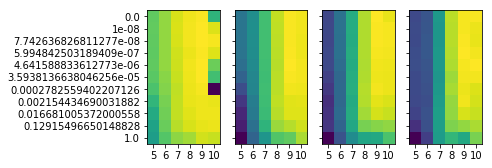

In [66]:
ax1 = plt.subplot(1,4,1)
plt.yticks(np.arange(len(LAMBDAS)), LAMBDAS)
plt.xticks(np.arange(len(DEGREES)), DEGREES)
plt.imshow(accs[0].T)
ax2 = plt.subplot(1,4,2, sharey=ax1, sharex=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.imshow(accs[1].T)
ax3 = plt.subplot(1,4,3, sharey=ax1, sharex=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.imshow(accs[2].T)
ax4 = plt.subplot(1,4,4, sharey=ax1, sharex=ax1)
plt.imshow(accs[3].T)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.show()

In [53]:
test_accs

[0.8443527540266454, 0.8039403825241477, 0.830749093838099, 0.8319055336883537]

### Now check score on test set

In [37]:
# return predictions
def predict_all(test_x, weights, degs):
    
    predictions = np.ones((test_x.shape[0],))
    
    # for every jet number
    for i in range(4):

        # get test data
        x, ids = data_of_jet_num(test_x, None, i)
        
        # clean test data (only remove undefined columns)
        clean_x = clean_data(x, MEDIANS[i], UNWANTED[i])

        expanded_x = expand_poly(clean_x, degs[i])

        # predict the labels
        p = predict(weights[i], expanded_x)
        
        predictions[ids] = p
        
    return predictions

In [38]:
# method that predicts and returns the accuracy
def check(test_x, test_y, weights, degs):
    predictions = predict_all(test_x, weights, degs)
    return accuracy(predictions, test_y)

In [39]:
check(TEST_X, TEST_Y, weights, best_degs)

0.82806

# Generate predictions and save ouput in csv format for submission:

In [40]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [46]:
y_pred = predict_all(tX_test, weights, best_degs)

In [47]:
OUTPUT_PATH = '../output/predictions_11.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)